In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from tests.leandro.tools import *
from tests.leandro.plots import *

import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform

from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

In [3]:
np.set_printoptions(precision=4, suppress=True)
plt.figure(figsize=(10, 3))
%matplotlib inline
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_51142/2937752703.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1000x300 with 0 Axes>

In [20]:
# Real data
dataset = get_real_data()
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset)


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Worm ID: worm35


# Hierarchically neuron clustering
---

In [21]:
oneWorm.keys()

dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])

In [22]:
X = oneWorm['smooth_calcium_data'] # (time, all neurons)
X = X[:, oneWorm['neurons_mask']]  # (time, acive neurons)
print("X.shape:", X.shape)

X.shape: torch.Size([9710, 123])


In [29]:
R = correlation_matrix(X)
R = (R + R.T) / 2  # Make it symmetric (just in case) -> numerical error
print("Correlation matrix shape:", R.shape)
D = 1 - R # Distance matrix
np.fill_diagonal(D, 0) # Make diagonal 0 (just in case)

Correlation matrix shape: (123, 123)


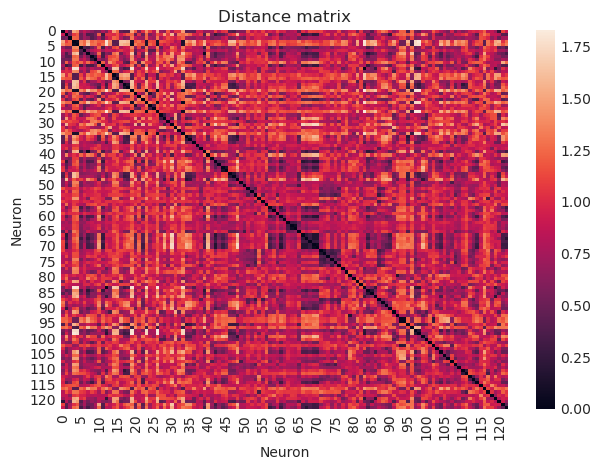

In [32]:
plotHeatmap(D, title="Distance matrix", xlabel="Neuron", ylabel="Neuron")

In [34]:
# The linkage function takes a condensed distance matrix, which is a flat array containing the upper triangular of the distance matrix. 
# We use squareform function to convert the matrix form to the condensed form.
condensed_D = squareform(D)
Z = linkage(condensed_D, method='complete')

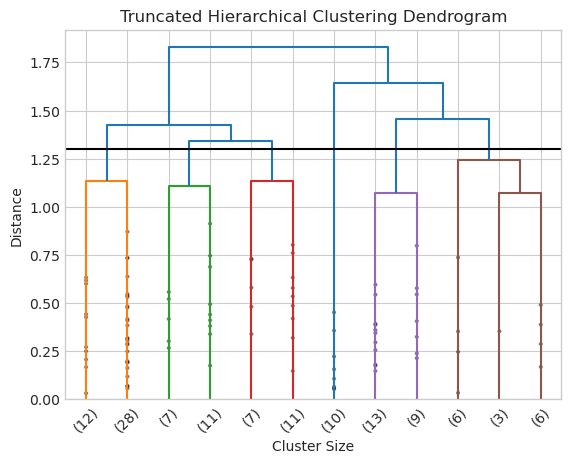

In [48]:
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=1.3, c='k')
plt.show()

In [57]:
# Now that we know how many clusters we want, we can cut the dendrogram at the desired number of clusters, and the cut_tree function will return a flat clustering.
distance = 1.3
cluster_labels = fcluster(Z, distance, criterion='distance')
print("Clusters:", cluster_labels)

Clusters: [5 1 1 4 4 1 2 1 1 1 5 1 1 6 4 4 5 5 5 4 2 5 2 4 2 2 4 6 6 2 5 2 6 4 5 5 1
 6 3 1 5 1 1 1 1 1 5 5 5 6 3 2 3 2 5 3 3 1 1 3 1 1 1 1 1 3 1 1 1 1 1 3 3 3
 2 3 2 5 1 6 3 5 3 1 1 1 1 2 2 2 1 6 6 6 6 5 4 1 1 5 6 3 6 2 1 3 1 6 3 3 5
 5 3 2 2 6 4 5 2 1 5 1 1]


In [58]:
# We can also cut the dendrogram at a given number of clusters, and the cut_tree function will return a flat clustering.
k = 6
cluster_labels2 = fcluster(Z, k, criterion='maxclust')
print("Clusters:", cluster_labels2)

Clusters: [5 1 1 4 4 1 2 1 1 1 5 1 1 6 4 4 5 5 5 4 2 5 2 4 2 2 4 6 6 2 5 2 6 4 5 5 1
 6 3 1 5 1 1 1 1 1 5 5 5 6 3 2 3 2 5 3 3 1 1 3 1 1 1 1 1 3 1 1 1 1 1 3 3 3
 2 3 2 5 1 6 3 5 3 1 1 1 1 2 2 2 1 6 6 6 6 5 4 1 1 5 6 3 6 2 1 3 1 6 3 3 5
 5 3 2 2 6 4 5 2 1 5 1 1]


In [59]:
np.equal(cluster_labels, cluster_labels2).all()

True

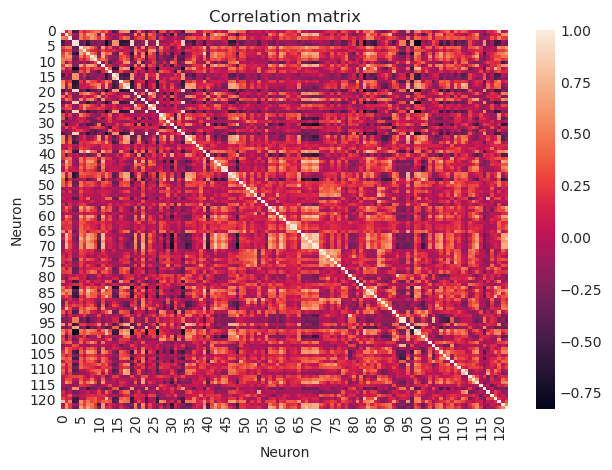

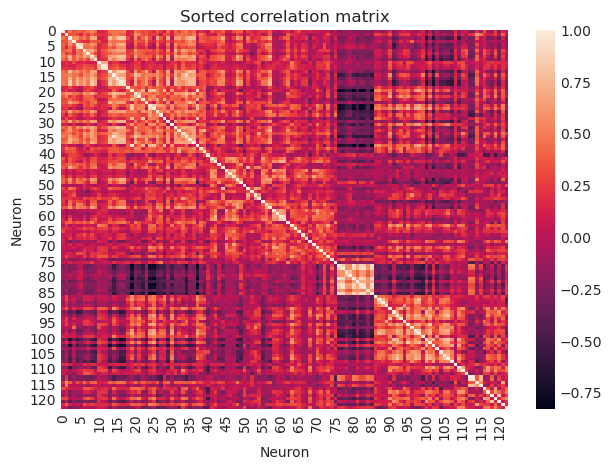

In [62]:
# Now we can sort the correlation matrix according to the cluster labels, and plot the correlation matrix again.
sorted_R = R[:, np.argsort(cluster_labels)]
sorted_R = sorted_R[np.argsort(cluster_labels), :]

# Plot
plotHeatmap(R, title="Correlation matrix", xlabel="Neuron", ylabel="Neuron")
plotHeatmap(sorted_R, title="Sorted correlation matrix", xlabel="Neuron", ylabel="Neuron")